In [1]:
# %%
import torch
from torch import nn
import numpy as np

from pit.dynamics.dynamic_bicycle import DynamicBicycle
from pit.dynamics.single_track import SingleTrack
from pit.parameters import NormalParameterGroup, CovariantNormalParameterGroup, PointParameterGroup
from pit.integration import Euler, RK4

import matplotlib.pyplot as plt
import json

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(DEVICE)

# input parameters
map_name = 'SaoPaulo'  # Nuerburgring,  SaoPaulo
lap_number = 2  # 1 - faster, 2 - slower
friction = '1-1'  # '1-1' - mu_x = 1.1, '0-7' - mu_x = 0.7

# visualization
# with open('dataset_%s_%s_lap%s.json' % (friction, map_name, lap_number), 'r') as f:
#     data = json.load(f)

with open('synced_data.json', 'r') as f:
     data = json.load(f)

cpu


/home/xlab/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# %%
timestep = 0.01
# assert(data['time'][1] - data['time'][0] - timestep < 0.001)
x = torch.tensor(data['x'][200:801])
y = torch.tensor(data['y'][200:801])
yaw = torch.tensor(data['yaw'][200:801])
yaw_rate = torch.tensor(data['yaw_rate'][200:801])
steer_angle = torch.tensor(data['steer_angle'][200:801])
# accel = torch.tensor(data['accel'][200:801])
accel = torch.tensor(data['linear_acceleration_x'][200:801]) 
# steer_speed = torch.tensor(data['steer_speed'][200:801])
delta_times = torch.tensor(data['dt'][200:801])
#set delta times to be 0.01
# delta_times = torch.ones_like(delta_times) * 0.2
time = torch.tensor(data['time'][200:801])

vx = torch.tensor(data['vx'][200:801])
vy = torch.tensor(data['vy'][200:801])

vy = -1 * vy
vx = -1 * vx

#Get the velocity array from vx and vy
v = torch.norm(torch.stack([vx, vy], dim=0), dim=0)
# v = np.linalg.norm(np.hstack([vx, vy]))
print(v.shape)

#Get the slip angle array from vx and vy
slip_angle = torch.atan2(vy, vx)
slip_angle = -1 * slip_angle
# try:
#     delta_times = torch.tensor(data['dt'])
# except KeyError:
#     delta_times = time[1:] - time[:-1]

torch.Size([601])


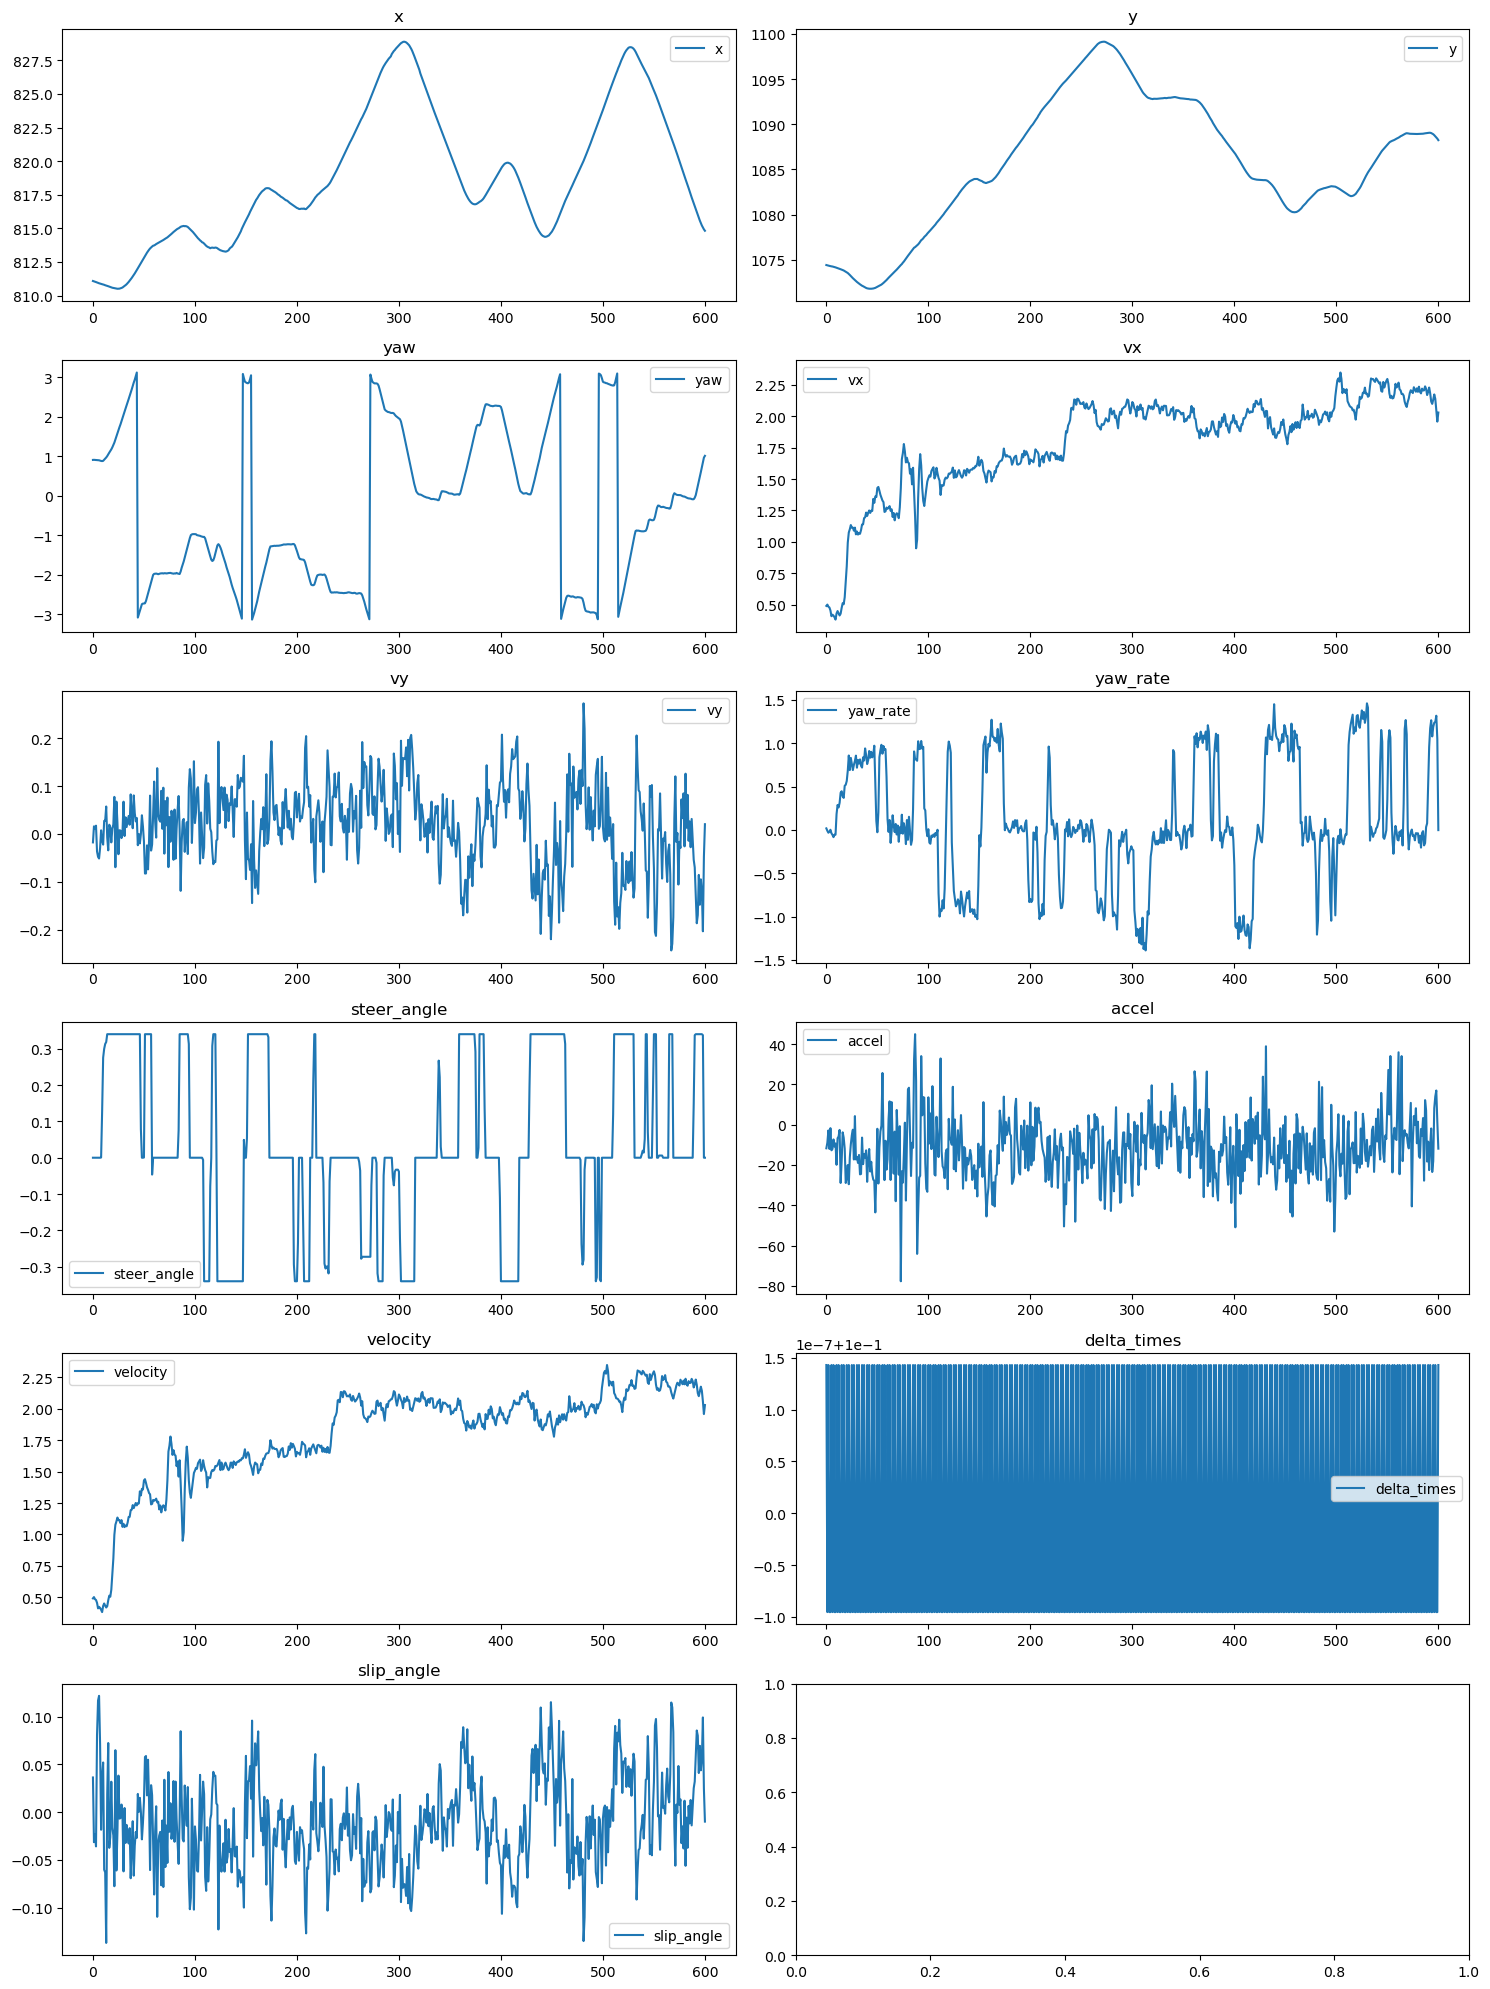

In [3]:
# Plot each tensor
fig, axs = plt.subplots(6, 2, figsize=(15, 20))

# Plot x and y
axs[0, 0].plot(x.numpy(), label='x')
axs[0, 0].set_title('x')
axs[0, 0].legend()

axs[0, 1].plot(y.numpy(), label='y')
axs[0, 1].set_title('y')
axs[0, 1].legend()

# Plot yaw and vx
axs[1, 0].plot(yaw.numpy(), label='yaw')
axs[1, 0].set_title('yaw')
axs[1, 0].legend()

axs[1, 1].plot(vx.numpy(), label='vx')
axs[1, 1].set_title('vx')
axs[1, 1].legend()

# Plot vy and yaw_rate
axs[2, 0].plot(vy.numpy(), label='vy')
axs[2, 0].set_title('vy')
axs[2, 0].legend()

axs[2, 1].plot(yaw_rate.numpy(), label='yaw_rate')
axs[2, 1].set_title('yaw_rate')
axs[2, 1].legend()

# Plot steer_angle and accel
axs[3, 0].plot(steer_angle.numpy(), label='steer_angle')
axs[3, 0].set_title('steer_angle')
axs[3, 0].legend()

axs[3, 1].plot(accel.numpy(), label='accel')
axs[3, 1].set_title('accel')
axs[3, 1].legend()

# # Plot steer_speed and delta_times
axs[4, 0].plot(v.numpy(), label='velocity')
axs[4, 0].set_title('velocity')
axs[4, 0].legend()

axs[4, 1].plot(delta_times.numpy(), label='delta_times')
axs[4, 1].set_title('delta_times')
axs[4, 1].legend()

axs[5, 0].plot(slip_angle.numpy(), label='slip_angle')
axs[5, 0].set_title('slip_angle')
axs[5, 0].legend()

# axs[5, 1].plot(untranslated_vy.numpy(), label='untranslated_vy')
# axs[5, 1].set_title('untranslated_vy')
# axs[5, 1].legend()

# Show the plots
plt.tight_layout()
plt.show()

In [4]:
# # state = [X Y V YAW YAW_RATE SLIP_ANGLE]
# initial_state = torch.tensor([x[0],y[0],yaw[0],vx[0],vy[0],yaw_rate[0],steer_angle[0]]).to(DEVICE)

initial_state = torch.tensor([x[0],y[0],v[0],yaw[0],yaw_rate[0],slip_angle[0]]).to(DEVICE)
control_inputs = torch.vstack([steer_angle, accel]).T
control_inputs = control_inputs.contiguous().to(DEVICE)
# output_states = torch.vstack([x, y, yaw, vx, vy, yaw_rate, steer_angle]).T
output_states = torch.vstack([x, y, v, yaw, yaw_rate, slip_angle]).T
target_states = output_states#[1:]
target_states = target_states.contiguous().to(DEVICE)


print(f"Inputs size: {control_inputs.shape} | States size: {target_states.shape}")

Inputs size: torch.Size([601, 2]) | States size: torch.Size([601, 6])


In [5]:
# %%
STEP_SIZE=10
TICKS_IN_STEP=10
state_dims = initial_state.shape[0]
input_dims = control_inputs.shape[-1]
total_steps = (control_inputs.shape[0]-TICKS_IN_STEP-1)//STEP_SIZE

batched_initial_states = torch.zeros((total_steps, state_dims), device=DEVICE)
batched_control_inputs = torch.zeros((total_steps, TICKS_IN_STEP, input_dims), device=DEVICE)
batched_target_states = torch.zeros((total_steps, TICKS_IN_STEP, state_dims), device=DEVICE)
batched_delta_time = torch.zeros((total_steps, TICKS_IN_STEP), device=DEVICE)

for step in range(total_steps):
    batched_initial_states[step] = output_states[step*STEP_SIZE]
    batched_control_inputs[step] = control_inputs[step*STEP_SIZE:(step*STEP_SIZE)+TICKS_IN_STEP]
    batched_target_states[step] = output_states[(step*  STEP_SIZE)+1:(step*STEP_SIZE)+TICKS_IN_STEP+1]
    batched_delta_time[step] = delta_times[step*STEP_SIZE:(step*STEP_SIZE)+TICKS_IN_STEP]

print(f"Batched Inputs size: {batched_control_inputs.shape} | Batched States size: {batched_target_states.shape}")

Batched Inputs size: torch.Size([59, 10, 2]) | Batched States size: torch.Size([59, 10, 6])


In [6]:
# %%
dataset = torch.utils.data.TensorDataset(batched_initial_states, batched_control_inputs, batched_target_states, batched_delta_time)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)

In [7]:
# %%
# params = {
#     # axes distances
#     'lf': 0.2725,  # distance from spring mass center of gravity to front axle [m]  LENA
#     'lr': 0.2585,  # distance from spring mass center of gravity to rear axle [m]  LENB

#     # moments of inertia of sprung mass
#     # masses
#     'Iz': 0.6433215993,  # moment of inertia for sprung mass in yaw [kg m^2]  IZZ
#     'mass': 15.32,  # vehicle mass [kg]  MASS

#     # Pacejka tire force parameters
#     'Df': 3709.08227,  # [rad/m]  DF
#     'Cf': 1.3507,
#     'Bf': 16.2216,
#     'Dr': 3709.08227,  # [rad/m]  DR
#     'Cr': 1.3507,
#     'Br': 16.2216,
#     'Cm': 0.3777,
#     'Cr0': 2.1469,
#     'Cr2': 0.0,
# }

single_track_params = {
    # Length and width of the vehicle
    'l': 0.8,
    'w': 0.55, 

    
    # moments of inertia of sprung mass
    # masses
    'm': 15.32,  # vehicle mass [kg]  MASS
    'Iz': 0.64332,  # moment of inertia for sprung mass in yaw [kg m^2]  IZZ
    
    # axes distances
    'lf': 0.02735,  # distance from spring mass center of gravity to front axle [m]  LENA
    'lr': 0.02585,  # distance from spring mass center of gravity to rear axle [m]  LENB

    # height of the center of gravity
    'hcg': 0.1875,  # height of the center of gravity [m]  HCG

    # tire cornering stiffness
    'Csf': 0.03,  # front tire cornering stiffness [N/rad]  CF
    'Csr': 0.03,  # rear tire cornering stiffness [N/rad]  CR

    # tire friction coefficient
    'mu': 0.7,  # tire friction coefficient  MU

}
single_track_params = {
	"l" : 0.800000011920929,
	"w" : 0.550000011920929,
	"m" : 15.319999694824219,
	"Iz" : 0.6433200240135193,
	"lf" : 0.02734999917447567,
	"lr" : 0.025849999859929085,
	"hcg" : 0.1875,
	"Csf" : 0.00019439533934928477,
	"Csr" : 0.7307889461517334,
	"mu" : 0.8126652836799622,
}


# params.update({
# 	"lf" : 0.27250000834465027,
# 	"lr" : 0.25850000977516174,
# 	"Iz" : 0.6433215737342834,
# 	"mass" : 15.319999694824219,
# 	"Df" : 3709.082275390625,
# 	"Cf" : 1.3507000207901,
# 	"Bf" : 16.221599578857422,
# 	"Dr" : 3709.082275390625,
# 	"Cr" : 1.3507000207901,
# 	"Br" : 16.221599578857422,
# 	"Cm" : 0.4104667901992798,
# 	"Cr0" : 1.9748075008392334,
# 	"Cr2" : 0.5565943121910095,
# })
# dynamics = DynamicBicycle(**params)
dynamics = SingleTrack(**single_track_params)
param_group = PointParameterGroup(dynamics.parameter_list, single_track_params)

# Disable gradients for physical parameters
for param in ['l', 'w', 'hcg', 'lf', 'lr', 'Iz', 'm']:
    param_group.disable_gradients(param)

for param in ['Csf', 'Csr', 'mu']:
    param_group.enable_gradients(param)
    
#dynamics = torch.load("fitted_model.pt")
# <---- FIX PHYSICAL PARAMS     ---->
# dynamics.lf.requires_grad = False
# dynamics.lr.requires_grad = False
# dynamics.mass.requires_grad = False
# dynamics.Iz.requires_grad = False
# dynamics.Df.requires_grad = True
# dynamics.Cf.requires_grad = True
# dynamics.Bf.requires_grad = True
# dynamics.Dr.requires_grad = True
# dynamics.Cr.requires_grad = True
# dynamics.Br.requires_grad = True
# dynamics.Cm.requires_grad = True
# dynamics.Cr0.requires_grad = True
# dynamics.Cr2.requires_grad = True
# <----                         ---->
# euler_integrator = Euler(dynamics, parameters=param_group, timestep=timestep)
# euler_integrator.to(DEVICE)
rk4_integrator = RK4(dynamics=dynamics, parameters=param_group, timestep=timestep)
rk4_integrator.to(DEVICE)

RK4(
  (dynamics): SingleTrack()
  (model_params): PointParameterGroup(
    (params): ParameterDict(
        (l): Parameter containing: [torch.FloatTensor of size ]
        (w): Parameter containing: [torch.FloatTensor of size ]
        (m): Parameter containing: [torch.FloatTensor of size ]
        (Iz): Parameter containing: [torch.FloatTensor of size ]
        (lf): Parameter containing: [torch.FloatTensor of size ]
        (lr): Parameter containing: [torch.FloatTensor of size ]
        (hcg): Parameter containing: [torch.FloatTensor of size ]
        (Csf): Parameter containing: [torch.FloatTensor of size ]
        (Csr): Parameter containing: [torch.FloatTensor of size ]
        (mu): Parameter containing: [torch.FloatTensor of size ]
    )
  )
)

In [8]:
with torch.no_grad():
    rk4_output_states = rk4_integrator(initial_state, control_inputs, delta_times)


In [9]:
#print first five euer output states
# initial_state = torch.tensor([x[0],y[0],yaw[0],vx[0],vy[0],yaw_rate[0],steer_angle[0]]).to(DEVICE)
print(rk4_output_states[10:20])

tensor([[ 813.3333, 1074.4479,  -10.4610,   -5.4142,  -29.6702,    4.2804],
        [ 812.8906, 1075.3956,  -11.1375,  -11.4883,  -32.5629,    6.7984],
        [ 812.9156, 1074.2821,  -11.7249,  -18.2655,  -36.4136,    9.4933],
        [ 813.8471, 1074.9941,  -11.9867,  -25.5315,  -37.8538,   12.9353],
        [ 812.6490, 1075.0298,  -14.8795,  -33.5016,  -83.4097,   10.5488],
        [ 813.5003, 1073.8094,  -16.7034,  -43.3953, -105.9483,   16.4300],
        [ 813.9326, 1075.4229,  -17.0852,  -54.5017, -110.9537,   26.5383],
        [ 815.5592, 1075.9456,  -17.7309,  -65.8620, -128.0414,   36.0097],
        [ 815.5466, 1074.1725,  -18.9235,  -77.6516, -176.4990,   44.3759],
        [ 816.0859, 1075.9863,  -21.8162,  -90.2342, -332.9150,   48.6027]])


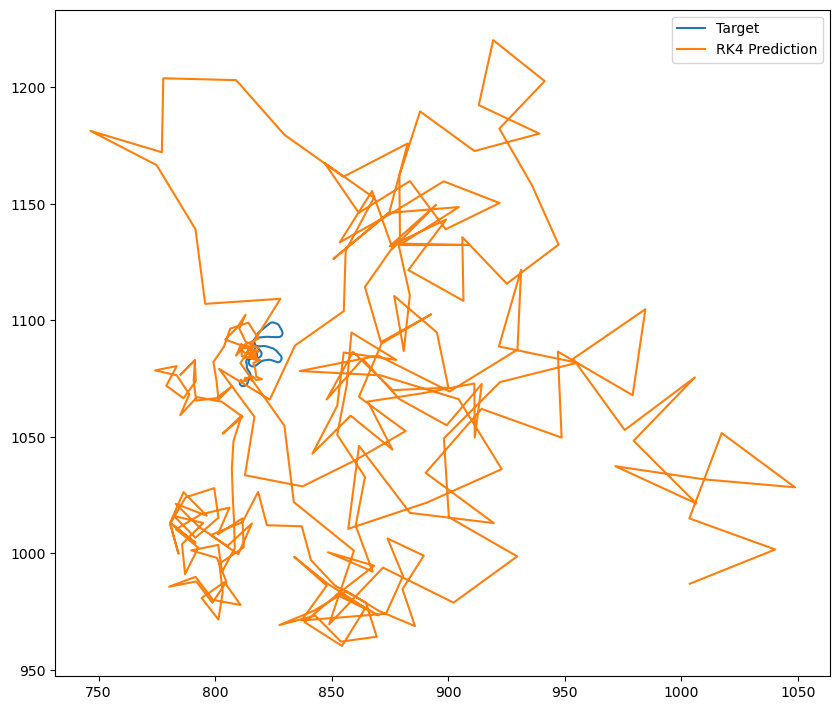

In [10]:
# %%
fig, ax = plt.subplots(1, 1, figsize=(10,10))
LEN=20000
ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")
# ax.plot(euler_output_states[:LEN, 0].detach().cpu().numpy(), euler_output_states[:LEN, 1].detach().cpu().numpy(), label="Euler Prediction")
ax.plot(rk4_output_states[:LEN, 0].detach().cpu().numpy(), rk4_output_states[:LEN, 1].detach().cpu().numpy(), label="RK4 Prediction")
ax.set_aspect(1.0)
ax.legend()

In [11]:
# %%
from tqdm.auto import tqdm
EPOCHS = 5000
integrator = rk4_integrator
optimizer = torch.optim.SGD(integrator.parameters(), lr=1e-2, momentum=0.8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.9)

with torch.no_grad():
        output_states = integrator(initial_state, control_inputs)
        val_loss = torch.nn.functional.l1_loss(output_states, target_states)
print(f"Initialized | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")

losses = list()
lrs = list()

for i in tqdm(range(EPOCHS)):
    for initial, inputs, targets, dts in dataloader:
        integrator.train()
        optimizer.zero_grad()
        output_states = integrator(initial, inputs, dts)
        loss = torch.nn.functional.l1_loss(output_states, targets)
        loss.backward()
        optimizer.step()
    #for name, param in integrator.named_parameters():
    #    if param.requires_grad:
    #        print(name, param.data, param.grad)
    if i%20 == 0 and False:
        with torch.no_grad():
            output_states = integrator(initial_state, control_inputs, dts)
            val_loss = torch.nn.functional.l1_loss(output_states, target_states)
        fig, ax = plt.subplots(1, 1, figsize=(10,10))
        LEN=20000
        ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")
        ax.plot(output_states[:LEN, 0].detach().cpu().numpy(), output_states[:LEN, 1].detach().cpu().numpy(), label="Prediction")
        ax.set_aspect(1.0)
        ax.legend()
        plt.show()
        print(f"Epoch: {i} | Training Loss: {loss.item()} | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
    with torch.no_grad():
        integrator.eval()
        output_states = integrator(batched_initial_states,batched_control_inputs, batched_delta_time)
        val_loss = torch.nn.functional.l1_loss(output_states, batched_target_states)
        losses.append(val_loss.item())
    print(f"Epoch: {i} | Training Loss: {loss.item()} | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step(val_loss)


/home/xlab/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initialized | Validation Loss: 296409.3125 | LR: 0.01


  0%|          | 0/5000 [00:00<?, ?it/s]


NameError: name 'lf_b' is not defined

In [ ]:
initial.shape, inputs.shape, targets.shape, dts.shape

In [ ]:
fig, ax = plt.subplots()
ax.plot(losses, label='Training Loss')
ax.set_ylabel("Training Loss")
ax.set_yscale('log')
secax = ax.twinx()
secax.set_ylabel("Learning Rate")
secax.plot(lrs, label="Learning Rates", color='orange')
#secax.set_yscale('log')
ax.set_title("Training Losses")
fig.legend()
plt.show()

In [14]:
# %%
with torch.no_grad():
    integrator.eval()
    output_states = integrator(initial_state, control_inputs, delta_times)
    val_loss = torch.nn.functional.l1_loss(output_states, target_states)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
LEN=20000
ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")
ax.plot(output_states[:LEN, 0].detach().cpu().numpy(), output_states[:LEN, 1].detach().cpu().numpy(), label="Prediction")
ax.set_aspect(1.0)
ax.legend()
ax.set_title("Loss {:4f}".format(val_loss.item()))
plt.show()

In [ ]:
print("{")
for key in param_group.state_dict().keys():
    print(f"\t\"{key}\" : {param_group .state_dict()[key]},")
print("}")